# Corrections of OCRd text in Trove's newspapers

The full text of newspaper articles in Trove is extracted from page images using Optical Character Recognition (OCR). The accuracy of the OCR process is influenced by a range of factors including the font and the quality of the images. Many errors slip through. Volunteers have done a remarkable job in correcting these errors, but it's a huge task. This notebook explores the scale of OCR correction in Trove.

There are two ways of getting data about OCR corrections using the Trove API. To get aggregate data you can include `has:corrections` in your query to limit the results to articles that have at least one OCR correction.

To get information about the number of corrections made to the articles in your results, you can add the `reclevel=full` parameter to include the number of corrections and details of the most recent correction to the article record. For example, note the `correctionCount` and `lastCorrection` values in the record below:

``` json
{
    "article": {
        "id": "41697877",
        "url": "/newspaper/41697877",
        "heading": "WRAGGE AND WEATHER CYCLES.",
        "category": "Article",
        "title": {
            "id": "101",
            "value": "Western Mail (Perth, WA : 1885 - 1954)"
        },
        "date": "1922-11-23",
        "page": 4,
        "pageSequence": 4,
        "troveUrl": "https://trove.nla.gov.au/ndp/del/article/41697877",
        "illustrated": "N",
        "wordCount": 1054,
        "correctionCount": 1,
        "listCount": 0,
        "tagCount": 0,
        "commentCount": 0,
        "lastCorrection": {
            "by": "*anon*",
            "lastupdated": "2016-09-12T07:08:57Z"
        },
        "identifier": "https://nla.gov.au/nla.news-article41697877",
        "trovePageUrl": "https://trove.nla.gov.au/ndp/del/page/3522839",
        "pdf": "https://trove.nla.gov.au/ndp/imageservice/nla.news-page3522839/print"
    }
}
```

## Setting things up

In [1]:
import requests
import os
import ipywidgets as widgets
from operator import itemgetter # used for sorting
import pandas as pd # makes manipulating the data easier
import altair as alt
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm.auto import tqdm
from IPython.display import display, HTML, FileLink, clear_output
import math
from collections import OrderedDict
import time

# Make sure data directory exists
os.makedirs('data', exist_ok=True)

# Create a session that will automatically retry on server errors
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))
s.mount('https://', HTTPAdapter(max_retries=retries))

In [2]:
# Are you using JupyterLab or the classic Jupyter notebook?
# If you're using the classic notebook, uncomment the following line to make sure Altair charts appear as expected!

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [57]:
api_key = ''
print('Your API key is: {}'.format(api_key))

Your API key is: 


In [4]:
# Basic parameters for Trove API
params = {
    'facet': 'year', # Get the data aggregated by year.
    'zone': 'newspaper',
    'key': api_key,
    'encoding': 'json',
    'n': 0 # We don't need any records, just the facets!
}

In [5]:
def get_results(params):
    '''
    Get JSON response data from the Trove API.
    Parameters:
        params
    Returns:
        JSON formatted response data from Trove API 
    '''
    response = s.get('https://api.trove.nla.gov.au/v2/result', params=params, timeout=30)
    response.raise_for_status()
    # print(response.url) # This shows us the url that's sent to the API
    data = response.json()
    return data

## How many newspaper articles have corrections?

Let's find out what proportion of newspaper articles have at least one OCR correction.

First we'll get to the total number of newspaper articles in Trove.

In [6]:
# Set the q parameter to a single space to get everything
params['q'] = ' '

# Get the data from the API
data = get_results(params)

# Extract the total number of results
total = int(data['response']['zone'][0]['records']['total'])
print('{:,}'.format(total))

225,015,138


Now we'll set the `q` parameter to `has:corrections` to limit the results to newspaper articles that have at least one correction.

In [7]:
# Set the q parameter to 'has:corrections' to limit results to articles with corrections
params['q'] = 'has:corrections'

# Get the data from the API
data = get_results(params)

# Extract the total number of results
corrected = int(data['response']['zone'][0]['records']['total'])
print('{:,}'.format(corrected))

10,852,606


Calculate the proportion of articles with corrections.

In [8]:
print('{:.2%} of articles have at least one correction'.format(corrected/total))

4.82% of articles have at least one correction


You might be thinking that these figures don't seem to match the number of corrections by individuals displayed on the digitised newspapers home page. Remember that these figures show the **number of articles** that include corrections, while the individual scores show the **number of lines** corrected by each volunteer.

## Number of corrections by year

In [9]:
def get_facets(data):
    '''
    Loop through facets in Trove API response, saving terms and counts.
    Parameters:
        data  - JSON formatted response data from Trove API  
    Returns:
        A list of dictionaries containing: 'term', 'total_results'
    '''
    facets = []
    try:
        # The facets are buried a fair way down in the results
        # Note that if you ask for more than one facet, you'll have use the facet['name'] param to find the one you want
        # In this case there's only one facet, so we can just grab the list of terms (which are in fact the results by year)
        for term in data['response']['zone'][0]['facets']['facet']['term']:
            
            # Get the year and the number of results, and convert them to integers, before adding to our results
            facets.append({'term': term['search'], 'total_results': int(term['count'])})
            
        # Sort facets by year
        facets.sort(key=itemgetter('term'))
    except TypeError:
        pass
    return facets

def get_facet_data(params, start_decade=180, end_decade=201):
    '''
    Loop throught the decades from 'start_decade' to 'end_decade',
    getting the number of search results for each year from the year facet.
    Combine all the results into a single list.
    Parameters:
        params - parameters to send to the API
        start_decade
        end_decade
    Returns:
        A list of dictionaries containing 'year', 'total_results' for the complete 
        period between the start and end decades.
    '''
    # Create a list to hold the facets data
    facet_data = []
    
    # Loop through the decades
    for decade in tqdm(range(start_decade, end_decade + 1)):
        
        print(params)
        # Avoid confusion by copying the params before we change anything.
        search_params = params.copy()
        
        # Add decade value to params
        search_params['l-decade'] = decade
        
        # Get the data from the API
        data = get_results(search_params)
        
        # Get the facets from the data and add to facets_data
        facet_data += get_facets(data)
        
    # Reomve the progress bar (you can also set leave=False in tqdm, but that still leaves white space in Jupyter Lab)
    clear_output()
    return facet_data

In [10]:
facet_data = get_facet_data(params)

In [11]:
# Convert our data to a dataframe called df
df = pd.DataFrame(facet_data)

In [12]:
df.head()

,term,total_results
0,1803,526
1,1804,619
2,1805,430
3,1806,367
4,1807,134


In [13]:
# Reset the 'q' parameter
# Use a an empty search (a single space) to get ALL THE ARTICLES
params['q'] = ' '

# Get facet data for all articles
all_facet_data = get_facet_data(params)

In [14]:
# Convert the results to a dataframe
df_total = pd.DataFrame(all_facet_data)

In [15]:
def merge_df_with_total(df, df_total, how='left'):
    '''
    Merge dataframes containing search results with the total number of articles by year.
    This is a left join on the year column. The total number of articles will be added as a column to 
    the existing results.
    Once merged, do some reorganisation and calculate the proportion of search results.
    Parameters:
        df - the search results in a dataframe
        df_total - total number of articles per year in a dataframe
    Returns:
        A dataframe with the following columns - 'year', 'total_results', 'total_articles', 'proportion' 
        (plus any other columns that are in the search results dataframe).
    '''
    # Merge the two dataframes on year
    # Note that we're joining the two dataframes on the year column
    df_merged = pd.merge(df, df_total, how=how, on='term')

    # Rename the columns for convenience
    df_merged.rename({'total_results_y': 'total_articles'}, inplace=True, axis='columns')
    df_merged.rename({'total_results_x': 'total_results'}, inplace=True, axis='columns')

    # Set blank values to zero to avoid problems
    df_merged['total_results'] = df_merged['total_results'].fillna(0).astype(int)

    # Calculate proportion by dividing the search results by the total articles
    df_merged['proportion'] = df_merged['total_results'] / df_merged['total_articles']
    return df_merged

In [16]:
# Merge the search results with the total articles
df_merged = merge_df_with_total(df, df_total)
df_merged.head()

,term,total_results,total_articles,proportion
0,1803,526,526,1.0
1,1804,619,619,1.0
2,1805,430,430,1.0
3,1806,367,367,1.0
4,1807,134,134,1.0


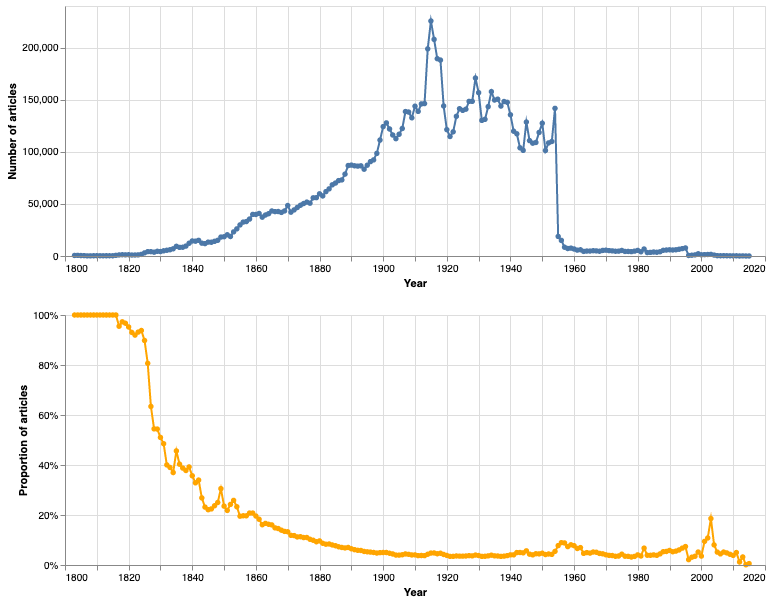

In [17]:
chart1 = alt.Chart(df).mark_line(point=True).encode(
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        tooltip=[alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=250)

chart2 = alt.Chart(df_merged).mark_line(point=True, color='red').encode(
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # This time we're showing the proportion (formatted as a percentage) on the Y axis
        y=alt.Y('proportion:Q', axis=alt.Axis(format='%', title='Proportion of articles')),
        tooltip=[alt.Tooltip('term:Q', title='Year'), alt.Tooltip('proportion:Q', title='Proportion', format='%')],
        
        # Make the charts different colors
        color=alt.value('orange')
    ).properties(width=700, height=250)

# This is a shorthand way of stacking the charts on top of each other
chart1 & chart2

## Number of corrections by category

In [18]:
params['q'] = 'has:corrections'
params['facet'] = 'category'

In [19]:
data = get_results(params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'term': term['search'], 'total_results': int(term['count'])})
df_categories = pd.DataFrame(facets)

In [20]:
df_categories.head()

,term,total_results
0,Article,8216008
1,Family Notices,1227802
2,Advertising,1029204
3,"Detailed Lists, Results, Guides",380902
4,Literature,5659


In [21]:
params['q'] = ' '
data = get_results(params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'term': term['search'], 'total_results': int(term['count'])})
df_total_categories = pd.DataFrame(facets)

In [22]:
df_categories_merged = merge_df_with_total(df_categories, df_total_categories)
df_categories_merged

,term,total_results,total_articles,proportion
0,Article,8216008,156930606,0.052354
1,Family Notices,1227802,1845548,0.665278
2,Advertising,1029204,40643498,0.025323
3,"Detailed Lists, Results, Guides",380902,25589737,0.014885
4,Literature,5659,25559,0.221409
5,Obituaries,4507,4737,0.951446
6,Humour,3654,15508,0.235620
7,"Law, Courts, And Crime",2983,4105,0.726675
8,News,2726,3541,0.769839
9,Sport And Games,2224,4038,0.550768


In [23]:
df_categories_filtered = df_categories_merged.loc[df_categories_merged['total_articles'] > 5000]
df_categories_filtered

,term,total_results,total_articles,proportion
0,Article,8216008,156930606,0.052354
1,Family Notices,1227802,1845548,0.665278
2,Advertising,1029204,40643498,0.025323
3,"Detailed Lists, Results, Guides",380902,25589737,0.014885
4,Literature,5659,25559,0.221409
6,Humour,3654,15508,0.235620
10,Letters,1187,6368,0.186401
12,Puzzles,862,7258,0.118766


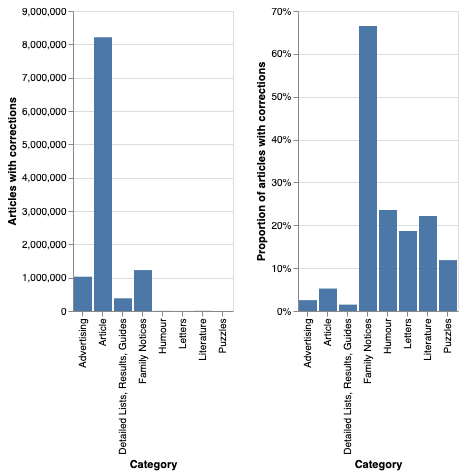

In [24]:
cat_chart1 = alt.Chart(df_categories_filtered).mark_bar().encode(
    x=alt.X('term:N', title='Category'),
    y=alt.Y('total_results:Q', title='Articles with corrections')
)

cat_chart2 = alt.Chart(df_categories_filtered).mark_bar().encode(
    x=alt.X('term:N', title='Category'),
    y=alt.Y('proportion:Q', axis=alt.Axis(format='%', title='Proportion of articles with corrections')),
)

cat_chart1 | cat_chart2

## Number of corrections by newspaper

In [25]:
params['q'] = 'has:corrections'
params['facet'] = 'title'

In [26]:
data = get_results(params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'term': term['search'], 'total_results': int(term['count'])})
df_newspapers = pd.DataFrame(facets)

In [27]:
df_newspapers.head()

,term,total_results
0,35,741002
1,13,719478
2,16,307910
3,11,287229
4,30,268359


Get the total number of articles per newspaper.

In [28]:
params['q'] = ' '

In [29]:
data = get_results(params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'term': term['search'], 'total_results': int(term['count'])})
df_newspapers_total = pd.DataFrame(facets)

In [30]:
df_newspapers_merged = merge_df_with_total(df_newspapers, df_newspapers_total, how='right')

In [31]:
df_newspapers_merged.sort_values(by='proportion', ascending=False, inplace=True)
df_newspapers_merged.rename(columns={'term': 'id'}, inplace=True)

In [32]:
df_newspapers_merged.head()

,id,total_results,total_articles,proportion
1272,1047,38,38,1.0
1233,118,56,56,1.0
1340,201,17,17,1.0
875,1142,437,437,1.0
1317,1042,21,21,1.0


Let's get the names of the newspapers.

In [33]:
title_params = {
    'key': api_key,
    'encoding': 'json',
}

title_data = s.get('https://api.trove.nla.gov.au/v2/newspaper/titles', params=params).json()

In [34]:
titles = []
for newspaper in title_data['response']['records']['newspaper']:
    titles.append({'title': newspaper['title'], 'id': int(newspaper['id'])})
df_titles = pd.DataFrame(titles)

In [35]:
df_titles.head()

,id,title
0,166,Canberra Community News (ACT : 1925 - 1927)
1,165,Canberra Illustrated: A Quarterly Magazine (AC...
2,69,"Federal Capital Pioneer (Canberra, ACT : 1924 ..."
3,871,Good Neighbour (ACT : 1950 - 1969)
4,665,Student Notes/Canberra University College Stud...


In [36]:
df_titles.shape

(1465, 2)

Exclude the government gazettes.

In [37]:
gazette_data = s.get('https://api.trove.nla.gov.au/v2/gazette/titles', params=params).json()
gazettes = []
for gaz in gazette_data['response']['records']['newspaper']:
    gazettes.append({'title': gaz['title'], 'id': int(gaz['id'])})
df_gazettes = pd.DataFrame(gazettes)

In [38]:
df_gazettes.shape

(37, 2)

In [39]:
df_titles_not_gazettes = df_titles[~df_titles['id'].isin(df_gazettes['id'])]

In [40]:
df_newspapers_with_titles = pd.merge(df_titles_not_gazettes, df_newspapers_merged, how='left', on='id').fillna(0).sort_values(by='proportion', ascending=False)

In [41]:
# Convert the totals back to integers
df_newspapers_with_titles[['total_results', 'total_articles']] = df_newspapers_with_titles[['total_results', 'total_articles']].astype(int)

Most corrected.

In [42]:
df_newspapers_with_titles[:25]

,id,title,total_results,total_articles,proportion
1331,1142,Swan River Guardian (WA : 1836 - 1838),437,437,1.000000
802,1046,The Derwent Star and Van Diemen's Land Intelli...,12,12,1.000000
497,118,Moonta Herald and Northern Territory Gazette (...,56,56,1.000000
197,1042,"Society (Sydney, NSW : 1887)",21,21,1.000000
430,729,The Temora Telegraph and Mining Advocate (NSW ...,3,3,1.000000
177,1000,"Party (Sydney, NSW : 1942)",6,6,1.000000
838,1047,The Van Diemen's Land Gazette and General Adve...,38,38,1.000000
913,201,"Elsternwick Leader and East Brighton, ... (Vic...",17,17,1.000000
258,686,The Branxton Advocate: Greta and Rothbury Reco...,53,53,1.000000
17,51,The Australian Abo Call (National : 1938),78,78,1.000000


Least corrected.

In [43]:
df_newspapers_with_titles[-25:]

,id,title,total_results,total_articles,proportion
235,1500,"The Bananacoast Opinion (Coffs Harbour, NSW : ...",60,29322,0.002046
1396,1381,"The Voice of Freedom = Elefthera Phoni (Perth,...",1,511,0.001957
1140,1502,"The Express, Melton (Vic. 1943 - 1954)",68,35201,0.001932
1407,1433,The Wyalkatchem Wheatsheaf and Bencubbin Banne...,25,13265,0.001885
1303,1446,Narembeen Observer (WA : 1928 - 1933),42,23107,0.001818
1216,1395,Ballidu-Wongan Budget (WA : 1927 - 1941),114,63251,0.001802
1263,1417,Gnowangerup Star (WA : 1941 - 1954),27,15774,0.001712
49,1492,"Border Morning Mail (Albury, NSW : 1938 - 1943)",442,268927,0.001644
1218,1397,Bonnie Rock-Lake Brown-Mukinbudin Leader (WA :...,17,12885,0.001319
591,1481,Toowoomba Chronicle and Darling Downs Gazette ...,786,611636,0.001285


In [44]:
df_newspapers_with_titles_csv = df_newspapers_with_titles.copy()
df_newspapers_with_titles_csv.rename({'total_results': 'articles_with_corrections'}, axis=1, inplace=True)
df_newspapers_with_titles_csv['percentage_with_corrections'] = df_newspapers_with_titles_csv['proportion'] * 100
df_newspapers_with_titles_csv.sort_values(by=['percentage_with_corrections'], inplace=True)
df_newspapers_with_titles_csv[['id', 'title', 'articles_with_corrections', 'total_articles', 'percentage_with_corrections']].to_csv('titles_corrected.csv', index=False)
#df_newspapers_with_titles.to_csv('titles_corrected.csv', index=False)

In [56]:
display(FileLink('titles_corrected.csv'))

/Volumes/Workspace/mycode/glam-workbench/trove-newspapers/notebooks/titles_corrected.csv

## Neediest newspapers

Let's see if we can combine some guesses about OCR error rates with the correction data to find the newspapers most in need of help.

To make a guesstimate of error rates, we'll use the occurance of 'tbe' – ie a common OCR error for 'the'. I don't know how valid this is, but it's a place to start.

In [45]:
params['q'] = 'text:"tbe"~0'
params['facet'] = 'title'

In [46]:
data = get_results(params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'term': term['search'], 'total_results': int(term['count'])})
df_errors = pd.DataFrame(facets)

In [47]:
df_errors_merged = merge_df_with_total(df_errors, df_newspapers_total, how='right')
df_errors_merged.sort_values(by='proportion', ascending=False, inplace=True)
df_errors_merged.rename(columns={'term': 'id'}, inplace=True)

In [48]:
df_errors_merged.head()

,id,total_results,total_articles,proportion
544,1316,2013,2954,0.681449
343,758,5271,8078,0.652513
245,927,9557,17227,0.554769
295,382,6980,12744,0.547709
314,262,6313,11527,0.547671


In [49]:
df_errors_with_titles = pd.merge(df_titles_not_gazettes, df_errors_merged, how='left', on='id').fillna(0).sort_values(by='proportion', ascending=False)

In [50]:
df_errors_with_titles[:25]

,id,title,total_results,total_articles,proportion
449,1316,"The Weekly Advance (Granville, NSW : 1892 - 1893)",2013,2954,0.681449
910,758,Dunolly and Betbetshire Express and County of ...,5271,8078,0.652513
953,927,Hamilton Spectator and Grange District Adverti...,9557,17227,0.554769
478,382,Wagga Wagga Express and Murrumbidgee District ...,6980,12744,0.547709
574,262,"The North Australian, Ipswich and General Adve...",6313,11527,0.547671
573,264,"The North Australian (Brisbane, Qld. : 1863 - ...",2894,5314,0.544599
788,1250,"Telegraph (Hobart Town, Tas. : 1867)",75,140,0.535714
778,1242,Morning Star and Commercial Advertiser (Hobart...,891,1703,0.523194
315,725,"The Hay Standard and Advertiser for Balranald,...",21737,42068,0.516711
191,530,Robertson Advocate (NSW : 1894 - 1923),37158,72383,0.513353


In [51]:
df_errors_with_titles[-25:]

,id,title,total_results,total_articles,proportion
1224,1460,Bullfinch Miner and Yilgarn Advocate (WA : 1910),0,27,0.0
691,314,"Suedaustralische Zeitung (Adelaide, SA : 1850 ...",0,47,0.0
697,1305,"The Citizen (Port Adelaide, SA : 1938-1940)",0,1284,0.0
197,1042,"Society (Sydney, NSW : 1887)",0,21,0.0
930,233,"Frankston Standard (Frankston, Vic. : 1949)",0,1997,0.0
1330,1379,"Sunday Times Edizione Italiana (Perth, WA : 19...",0,455,0.0
63,996,"Citizen Soldier (Sydney, NSW : 1942)",0,60,0.0
913,201,"Elsternwick Leader and East Brighton, ... (Vic...",0,17,0.0
656,1478,Port Augusta and Stirling Illustrated News (SA...,0,125,0.0
1155,935,The Melbourne Advertiser (Vic. : 1838),0,121,0.0


In [52]:
corrections_errors_merged_df = pd.merge(df_newspapers_with_titles, df_errors_with_titles, how='left', on='id')

In [53]:
corrections_errors_merged_df.head()

,id,title_x,total_results_x,total_articles_x,proportion_x,title_y,total_results_y,total_articles_y,proportion_y
0,1142,Swan River Guardian (WA : 1836 - 1838),437,437,1.0,Swan River Guardian (WA : 1836 - 1838),32,437,0.073227
1,1046,The Derwent Star and Van Diemen's Land Intelli...,12,12,1.0,The Derwent Star and Van Diemen's Land Intelli...,0,12,0.000000
2,118,Moonta Herald and Northern Territory Gazette (...,56,56,1.0,Moonta Herald and Northern Territory Gazette (...,0,56,0.000000
3,1042,"Society (Sydney, NSW : 1887)",21,21,1.0,"Society (Sydney, NSW : 1887)",0,21,0.000000
4,729,The Temora Telegraph and Mining Advocate (NSW ...,3,3,1.0,The Temora Telegraph and Mining Advocate (NSW ...,0,3,0.000000


In [54]:
corrections_errors_merged_df['proportion_uncorrected'] = corrections_errors_merged_df['proportion_x'].apply(lambda x: 1 - x)
corrections_errors_merged_df.rename(columns={'title_x': 'title', 'proportion_x': 'proportion_corrected', 'proportion_y': 'proportion_with_errors'}, inplace=True)
corrections_errors_merged_df.sort_values(by=['proportion_with_errors', 'proportion_uncorrected'], ascending=False, inplace=True)


In [55]:
corrections_errors_merged_df[['title', 'proportion_with_errors', 'proportion_uncorrected']][:25]

,title,proportion_with_errors,proportion_uncorrected
1294,"The Weekly Advance (Granville, NSW : 1892 - 1893)",0.681449,0.989506
552,Dunolly and Betbetshire Express and County of ...,0.652513,0.942065
419,Hamilton Spectator and Grange District Adverti...,0.554769,0.921809
394,Wagga Wagga Express and Murrumbidgee District ...,0.547709,0.917687
149,"The North Australian, Ipswich and General Adve...",0.547671,0.792053
214,"The North Australian (Brisbane, Qld. : 1863 - ...",0.544599,0.855852
460,"Telegraph (Hobart Town, Tas. : 1867)",0.535714,0.928571
150,Morning Star and Commercial Advertiser (Hobart...,0.523194,0.792132
942,"The Hay Standard and Advertiser for Balranald,...",0.516711,0.970500
760,Robertson Advocate (NSW : 1894 - 1923),0.513353,0.959977
